# EfficientDet for OpenWheat Competition

Links to Kaggle: 
* [EfficientDet training](https://www.kaggle.com/shonenkov/training-efficientdet)
* [EfficientDet inference](https://www.kaggle.com/shonenkov/inference-efficientdet)

In [53]:
import numpy as np
import pandas as pd

import time

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from datetime import datetime

import albumentations as albu
from albumentations.pytorch import ToTensor

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam,lr_scheduler

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm_notebook, tqdm

from glob import glob

import cv2
import gc

import os
import random
import shutil

sys.path.insert(0, "./weighted-boxes-fusion")

from ensemble_boxes import *

## Load and Clean Data

In [2]:
TRAIN_DIR = './global-wheat-detection/train/'

In [3]:
train_fns = glob('./global-wheat-detection/train/' + '*')
test_fns = glob('./global-wheat-detection/test/' + '*')

train_labels = pd.read_csv('./global-wheat-detection/train.csv')

# Create a dataframe with all train images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

# Merge all train images with the bounding boxes dataframe
all_train_images = all_train_images.merge(train_labels, on='image_id', how='left')

# replace nan values with zeros
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

# split bbox column
bbox_items = all_train_images.bbox.str.split(',', expand=True)
all_train_images['bbox_xmin'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['bbox_ymin'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['bbox_width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['bbox_height'] = bbox_items[3].str.strip(' ]').astype(float)

In [4]:
all_train_images['bbox_area'] = all_train_images['bbox_width'] * all_train_images['bbox_height']

In [5]:
max_area_threshold = 100000
min_area_threshold = 50

In [6]:
train_labels_cleaned = all_train_images[((all_train_images.bbox_area < max_area_threshold) & (all_train_images.bbox_area > min_area_threshold)) | (all_train_images.bbox_area == 0)]

In [7]:
train_labels_cleaned = train_labels_cleaned[train_labels_cleaned.width > 0].reindex()

In [8]:
train_labels_cleaned.head()

,image_id,width,height,bbox,source,bbox_xmin,bbox_ymin,bbox_width,bbox_height,bbox_area
0,ad62f80f2,1024.0,1024.0,"[335.0, 826.0, 148.0, 103.0]",arvalis_3,335.0,826.0,148.0,103.0,15244.0
1,ad62f80f2,1024.0,1024.0,"[330.0, 448.0, 194.0, 179.0]",arvalis_3,330.0,448.0,194.0,179.0,34726.0
2,ad62f80f2,1024.0,1024.0,"[734.0, 355.0, 287.0, 151.0]",arvalis_3,734.0,355.0,287.0,151.0,43337.0
3,ad62f80f2,1024.0,1024.0,"[71.0, 0.0, 103.0, 35.0]",arvalis_3,71.0,0.0,103.0,35.0,3605.0
4,ad62f80f2,1024.0,1024.0,"[650.0, 750.0, 79.0, 166.0]",arvalis_3,650.0,750.0,79.0,166.0,13114.0


## Prepare the Dataset

In [9]:
def get_train_transforms():
    return albu.Compose(
        [
            albu.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            albu.OneOf([
                albu.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                albu.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            albu.ToGray(p=0.01),
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5),
            albu.Resize(height=512, width=512, p=1),
            albu.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            albu.pytorch.transforms.ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=albu.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return albu.Compose(
        [
            albu.Resize(height=512, width=512, p=1.0),
            albu.pytorch.transforms.ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=albu.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [10]:
class WheatDataset(Dataset):

    def __init__(self, labels_df, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.labels_df = labels_df
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_DIR}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.labels_df[self.labels_df['image_id'] == image_id]
        boxes = records[['bbox_xmin', 'bbox_ymin', 'bbox_width', 'bbox_height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [11]:
test_split = 0.2

In [12]:
image_ids = train_labels_cleaned.image_id.unique()
dataset_size = len(image_ids)

indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]

In [13]:
train_dataset = WheatDataset(
    image_ids=image_ids[train_indices],
    labels_df=train_labels_cleaned,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = WheatDataset(
    image_ids=image_ids[test_indices],
    labels_df=train_labels_cleaned,
    transforms=get_valid_transforms(),
    test=True,
)

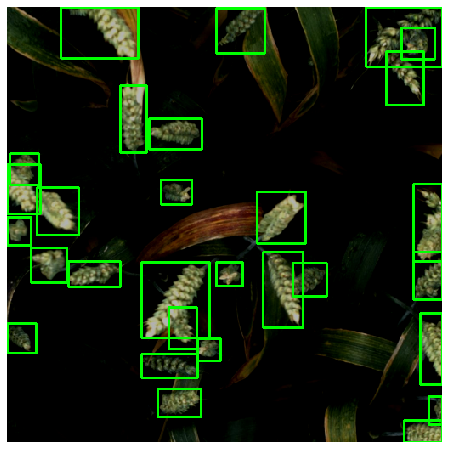

In [14]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## Fit the Model

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
import sys
sys.path.insert(0, "./timm-efficientdet-pytorch")

In [30]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet

In [19]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [20]:
device = torch.device('cuda:0')
net.to(device)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    sampler=RandomSampler(train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=4,
    collate_fn=collate_fn,
)
val_loader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=4,
    num_workers=4,
    shuffle=False,
    sampler=SequentialSampler(validation_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

In [21]:
class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [22]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4 
    n_epochs = 40
    lr = 0.0002

    folder = 'effdet5-cutmix-augmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=int(len(train_dataset) / batch_size),
#         pct_start=0.1,
#         anneal_strategy='cos', 
#         final_div_factor=10**5
#     )
    
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [23]:
fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
fitter.fit(train_loader, val_loader)

Fitter prepared. Device is cuda:0

2020-05-26T05:48:01.535553
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 2.44333, time: 237.31541
[RESULT]: Val. Epoch: 0, summary_loss: 1.58636, time: 25.50362

2020-05-26T05:52:25.924627
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.53031, time: 244.19205
[RESULT]: Val. Epoch: 1, summary_loss: 0.44565, time: 25.26508

2020-05-26T05:56:57.011954
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.47370, time: 249.53227
[RESULT]: Val. Epoch: 2, summary_loss: 0.40805, time: 26.49231

2020-05-26T06:01:34.548454
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.45651, time: 239.19358
[RESULT]: Val. Epoch: 3, summary_loss: 0.39330, time: 24.35091

2020-05-26T06:05:59.728641
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.44953, time: 238.05960
[RESULT]: Val. Epoch: 4, summary_loss: 0.40239, time: 24.26183

2020-05-26T06:10:22.835760
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.43626, time: 238.13298
[RESULT]: Val. Epoch:

## Inference

In [24]:
def get_valid_transforms():
    return albu.Compose([
            albu.Resize(height=512, width=512, p=1.0),
            albu.pytorch.transforms.ToTensorV2(p=1.0),
        ], p=1.0)

In [48]:
DATA_ROOT_PATH = './global-wheat-detection/test/'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [49]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [31]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

inference_net = load_net('./effdet5-cutmix-augmix/best-checkpoint-039epoch.bin')

In [32]:
def make_predictions(net, images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.55, skip_box_thr=0.45, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

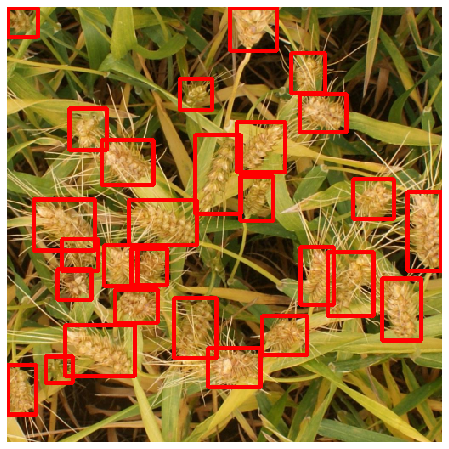

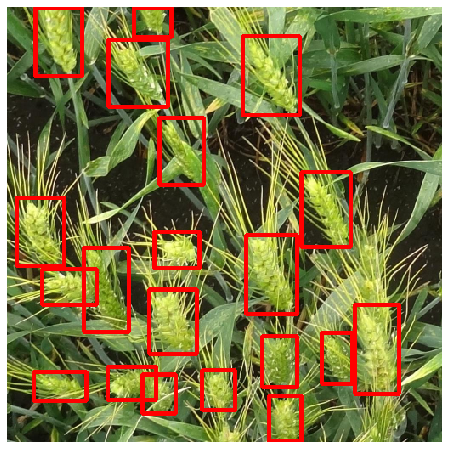

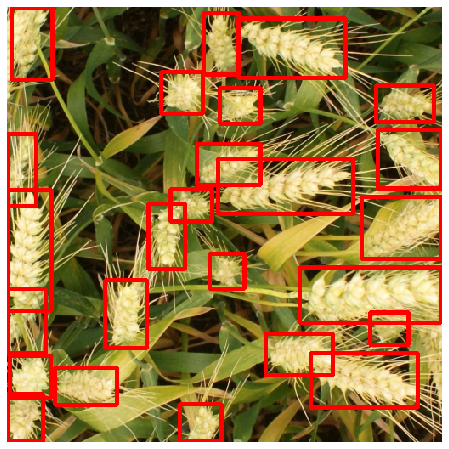

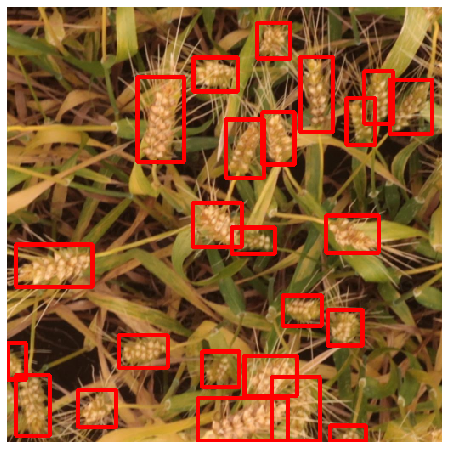

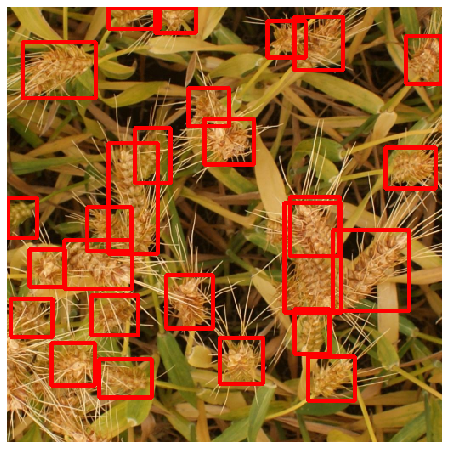

In [55]:
for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(inference_net, images)

    i = 0
    sample = images[i].permute(1,2,0).cpu().numpy()

    boxes, scores, labels = run_wbf(predictions, image_index=i)
    boxes = boxes.astype(np.int32).clip(min=0, max=511)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 4)

    ax.set_axis_off()
    ax.imshow(sample)
    plt.show()

In [56]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [58]:
results = []

for images, image_ids in data_loader:
    predictions = make_predictions(inference_net, images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [59]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,f5a1f0358,0.9091 943 434 80 187 0.9074 688 205 111 90 0....
1,cc3532ff6,0.9716 772 828 162 162 0.9261 563 304 110 113 ...
2,aac893a91,0.9025 563 537 119 185 0.8987 238 77 141 158 0...
3,2fd875eaa,0.9351 465 355 124 94 0.9349 532 868 111 123 0...
4,51b3e36ab,0.8904 112 849 146 87 0.8879 544 26 253 140 0....
